In [1]:
import os
os.chdir('../')
print(os.listdir())

['.git', '.gitignore', '.idea', 'architecture-design', 'Diplomska-draft.docx', 'Diplomski-trud-171217.docx', 'docker', 'drive-download-20211215T213754Z-001.zip', 'drive-download-20211221T190522Z-001.zip', 'evaluated-data', 'models', 'notebooks', 'README.md', 'scripts', 'simulated-data-raw', 'spark-warehouse', 'transformed-data', 'venv']


In [2]:
import pandas as pd
import findspark


findspark.init()
findspark.find()

from pyspark.sql import SparkSession
from pyspark.sql.functions import window, col, current_timestamp, when, count
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import sum,avg,max,min,mean,count, round


In [4]:
# Spark session & context
spark = (SparkSession
         .builder
         .master('local')
         .appName('transactions-evaluator')
         .config("spark.sql.streaming.schemaInference", True) #Stream dataframe infers schema
         .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.1.2")
         .getOrCreate())


In [5]:
sc = spark.sparkContext

# Read parquet stream
df_stream = (
        spark
        .readStream
        .format("parquet")
        .load("evaluated-data/dataset")
)
df_agg = (
    df_stream\
#     .filter(col("TX_FRAUD")!=col("prediction").cast("int"))
    .groupBy(window(col("TX_DATETIME"), "1 hour", "1 hour"))
    .agg(
        round(count("CUSTOMER_ID")/30,2).alias("nx_transactions"),
        count(when(col("TX_FRAUD")==1, 1).otherwise(None)).alias('nx_fraud_transactions'),
        count(when((col("TX_FRAUD")==1) & (col("prediction")==1), 1).otherwise(None)).alias("correct_fraud_predictions"),
        count(when((col("TX_FRAUD")==0) & (col("prediction")==1), 1).otherwise(None)).alias("false_positive_predictions")
    ))
queryStream = (df_agg
               .writeStream
               .format("memory")
               .queryName("df_stream")
               .outputMode("update")
               .start())

**********************
General Info
**********************
Run:15
Stream timestamp:2022-02-06T18:09:39.260Z


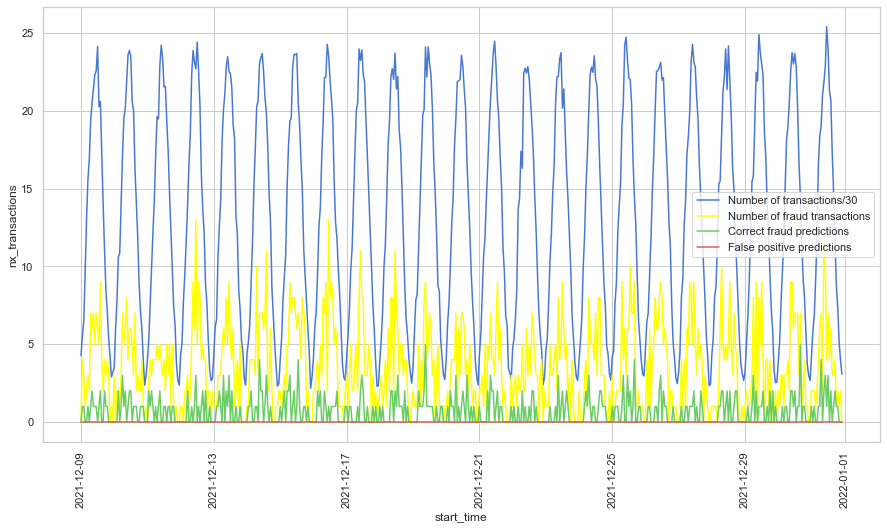

process interrupted.


In [6]:
from time import sleep
from IPython.display import clear_output
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('font', family='DejaVu Sans')
sns.set(style="whitegrid")


try:
    i=1
    while True:
        # Clear output
        clear_output(wait=True)
        print("**********************")
        print("General Info")
        print("**********************")
        print("Run:{}".format(i))
        if (len(queryStream.recentProgress) > 0):
            print("Stream timestamp:{}".format(queryStream.lastProgress["timestamp"]))
        
        df = spark.sql("select * from df_stream").toPandas()
        df['start_time']=df['window'].apply(lambda x: x[0])
        df = df.sort_values(by='start_time')
        sns.set_color_codes("muted")

        # Initialize the matplotlib figure
        plt.figure(figsize=(15, 8))

        try:

            # Barplot
            sns.lineplot(x="start_time", y="nx_transactions", data=df, color='b', label='Number of transactions/30')
            sns.lineplot(x="start_time", y="nx_fraud_transactions", data=df, color='yellow', label='Number of fraud transactions')
            sns.lineplot(x="start_time", y="correct_fraud_predictions", data=df, color='g', label='Correct fraud predictions')
            sns.lineplot(x="start_time", y="false_positive_predictions", data=df, color='r', label='False positive predictions')
            plt.xticks(rotation=90)
            # Show barplot
            plt.show()
        except ValueError:
            # If Dataframe is empty, pass
            pass


        sleep(30)
        i=i+1
except KeyboardInterrupt:
    print("process interrupted.")